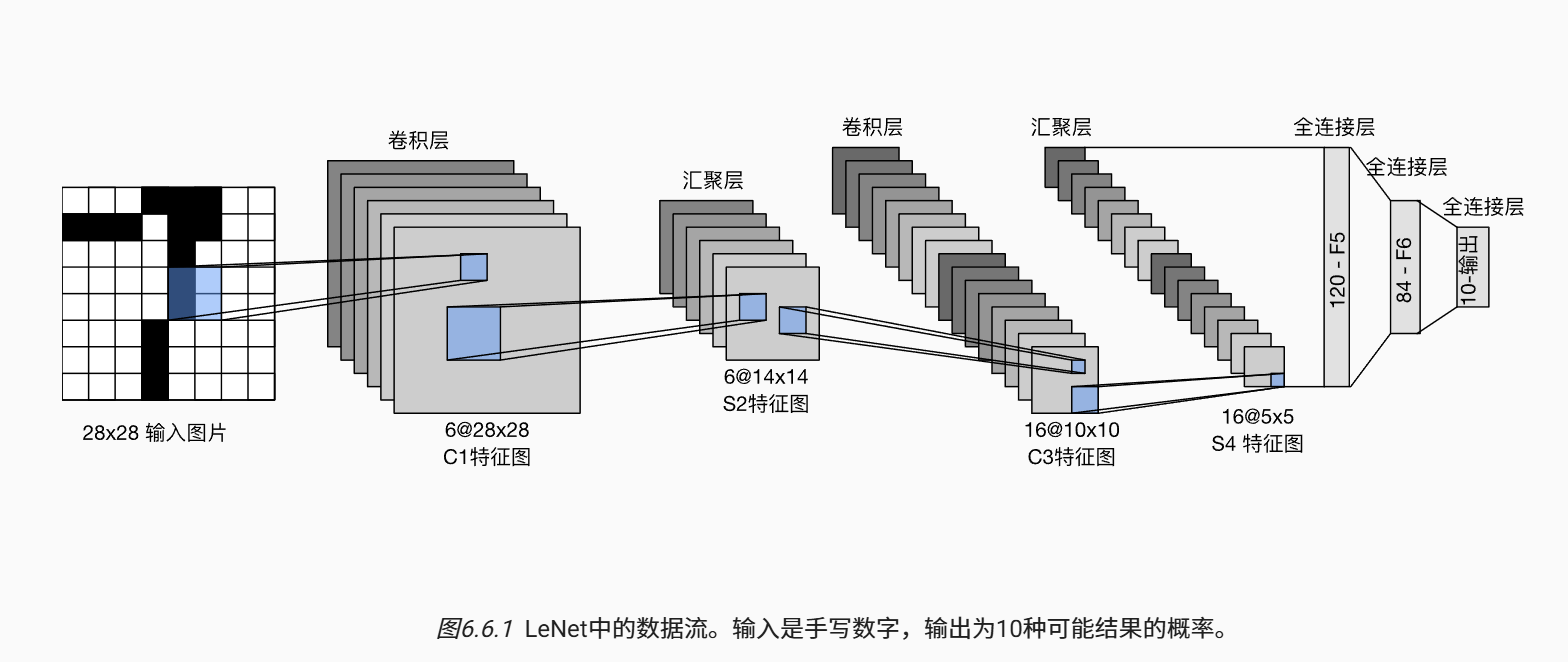

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),  # Input: 1x28x28, Output: 6x28x28
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),      # Output: 6x14x14
    nn.Conv2d(6, 16, kernel_size=5),           # Output: 16x10x10
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),      # Output: 16x5x5
    nn.Flatten(),                               # Flatten to 400 features
    nn.Linear(16 * 5 * 5, 120),                # Fully connected layer to 120 units
    nn.ReLU(),
    nn.Linear(120, 84),                         # Fully connected layer to 84 units
    nn.ReLU(),
    nn.Linear(84, 10)                           # Output layer for 10 classes
)

In [7]:
X = torch.rand(1,1,28,28,dtype=torch.float32)

for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [8]:
import traintools
batch_size = 256
train_iter,test_iter = traintools.load_data_fashion_mnist(_batch_size=batch_size)

def evaluate_accuracy(net,data_iter,device=None):
    if isinstance(net,nn.Module):
        net.eval()  # Set the model to evaluation mode
        if device is None:
            device = next(iter(net.parameters())).device  # Get the device from the model parameters

    metric = traintools.Accumulator(2)  # Initialize an accumulator for correct predictions and total samples
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for X,y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]  # Move input data to the specified device
            else:
                X = X.to(device)  # Move input data to the specified device
            y = y.to(device)  # Move labels to the specified device
            metric.add(traintools.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]  # Return the accuracy as the ratio

training on cuda:0
epoch 1, loss 0.876, train acc 0.666, test acc 0.763
epoch 2, loss 0.519, train acc 0.806, test acc 0.799
epoch 3, loss 0.449, train acc 0.834, test acc 0.824
epoch 4, loss 0.406, train acc 0.851, test acc 0.843
epoch 5, loss 0.377, train acc 0.862, test acc 0.857
epoch 6, loss 0.355, train acc 0.870, test acc 0.859
epoch 7, loss 0.341, train acc 0.873, test acc 0.852
epoch 8, loss 0.325, train acc 0.880, test acc 0.840
epoch 9, loss 0.315, train acc 0.882, test acc 0.870
epoch 10, loss 0.305, train acc 0.887, test acc 0.794


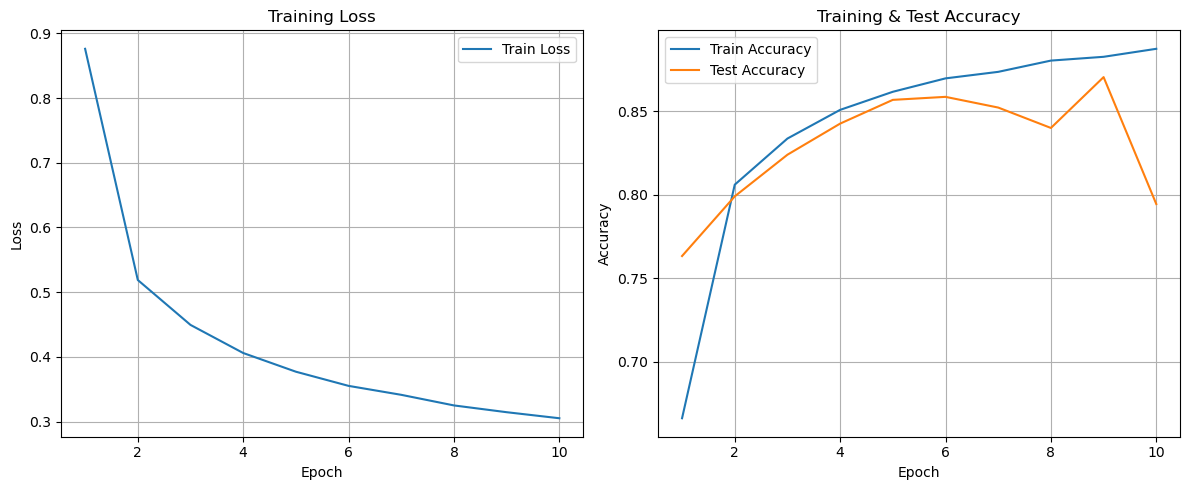

loss 0.305, train acc 0.887, test acc 0.794


In [11]:
lr,num_epochs = 0.09,10
traintools.train_ch6(net,train_iter,test_iter,num_epochs,lr,traintools.try_gpu())

为了构建高性能的卷积神经网路，通常需要对卷积层进行排列，逐渐降低其表示的空间分辨率，同时增加其通道数。LeNet-5是一个经典的卷积神经网络架构，包含两个卷积层和三个全连接层。它的设计理念是通过逐步降低空间分辨率来提取特征，同时增加通道数以增强模型的表达能力。